<a href="https://colab.research.google.com/github/JeonHG/1st-assignment/blob/master/vix_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 100)

In [45]:
# def pct_rank(series):
#   copied = series.copy()
#   copied.rename(copied.name + '_pct_rank', inplace=True)
#   return copied.rank(pct=True)

# def ror(series, periods=1):
#   copied = series.copy()
#   copied.rename(copied.name + '_ror', inplace=True)
#   return copied.pct_change(periods=periods)

def pct_rank(series):
  copied = series.copy()
  copied.rename(copied.name + '_pct_rank', inplace=True)
  return copied.rank(pct=True)

def ror(series, periods=1):
  copied = series.copy()
  copied.rename(f"{copied.name}_ror{periods}d", inplace=True)
  if periods >= 0:
    return copied.pct_change(periods=periods)
  else:
    return 1 / (copied.pct_change(periods=periods) + 1) - 1

def trigger_lt(df, column, threshold):
  return df[df[column] < threshold]

class Ticker:
  def __init__(self, ticker, period='max', interval='1d'):
    self.ticker = ticker
    self.period = period
    self.interval = interval
    self.df = self.__historical_price()

  def __historical_price(self):
    df = yf.download(self.ticker, period=self.period, interval=self.interval)
    df.rename(columns=str.lower, inplace=True)
    df.to_csv(f'/content/drive/MyDrive/quant-strategies/vix_strategy/{self.ticker}.csv')
    df.drop(columns=['high', 'low', 'adj close', 'volume'], inplace=True)
    df['intra_ror'] = (df['close'] - df['open']) / df['open']
    df = pd.concat([
        df,
        ror(df['open']),
        ror(df['close']),
        ror(df['close'], -5),
    ], axis=1)
    return pd.concat([
        df, 
        pct_rank(df['open']),
        pct_rank(df['close']),
        pct_rank(df['intra_ror']),
        pct_rank(df['open_ror1d']),
        pct_rank(df['close_ror1d']),
        # pct_rank(df['close_ror+5d']),
    ], axis=1)



In [46]:
ticker = Ticker('^vix').df

[*********************100%***********************]  1 of 1 completed


In [47]:
ticker

,open,close,intra_ror,open_ror1d,close_ror1d,close_ror-5d,open_pct_rank,close_pct_rank,intra_ror_pct_rank,open_ror1d_pct_rank,close_ror1d_pct_rank
Date,,,,,,,,,,,
1990-01-02,17.240000,17.240000,0.000000,NaN,NaN,0.287703,0.461860,0.464188,0.570670,NaN,NaN
1990-01-03,18.190001,18.190001,0.000000,0.055104,0.055104,0.233645,0.513370,0.515399,0.570670,0.826409,0.839422
1990-01-04,19.219999,19.219999,0.000000,0.056624,0.056624,0.043184,0.560523,0.566551,0.570670,0.831065,0.843840
1990-01-05,20.110001,20.110001,0.000000,0.046306,0.046306,0.225261,0.606184,0.613824,0.570670,0.792144,0.806351
1990-01-08,20.260000,20.260000,0.000000,0.007459,0.007459,0.300099,0.614838,0.620210,0.570670,0.583214,0.590735
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,22.049999,20.600000,-0.065760,-0.002714,-0.052438,NaN,0.697863,0.635788,0.087621,0.501433,0.166309
2023-03-28,20.530001,19.969999,-0.027277,-0.068934,-0.030583,NaN,0.628626,0.605229,0.305002,0.118553,0.294293
2023-03-29,19.389999,19.120001,-0.013925,-0.055529,-0.042564,NaN,0.570073,0.561836,0.420198,0.174427,0.218243


In [129]:
def strategy_result(ticker, ror_col, threshold, condition_col):
  trades = ticker[ticker[condition_col] < threshold][ror_col]
  result_dict = {
    'total_trades': len(trades),    
    'win_rates': round(len(trades[trades > 0]) / len(trades), 4),
    'average_ror': round(trades.mean(), 4),
    'average_ror_win': round(trades[trades > 0].mean(), 4),
    'average_ror_lose': round(trades[trades < 0].mean(), 4),
    'max_ror': max(trades),
    'min_ror': min(trades),
    'total_ror': round((1 + trades).product(), 4)
  }
  trades.to_csv(f'/content/drive/MyDrive/quant-strategies/vix_strategy/{ror_col}.csv')
  for key, value in result_dict.items():
    print(f'{key} : {value}')
  trades.plot(style='.')
  plt.show()
  trades.plot.hist(bins=int(len(trades) / 10))
  plt.show()
  trades.plot.density()
  plt.show()

total_trades : 837
win_rates : 0.644
average_ror : 0.05
average_ror_win : 0.1028
average_ror_lose : -0.0461
max_ror : 0.9776054921128012
min_ror : -0.20034247358289559
total_ror : 4510230346263892.0


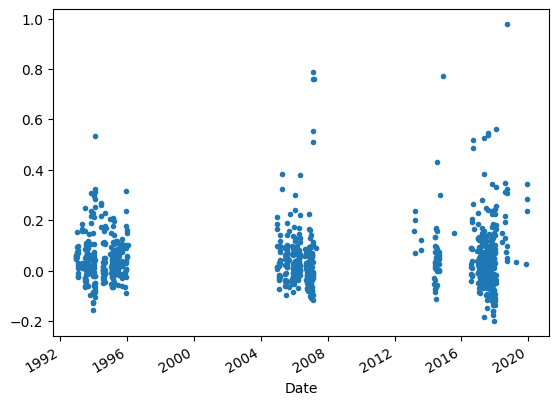

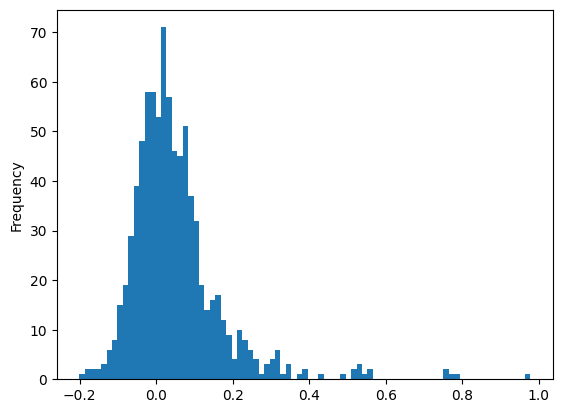

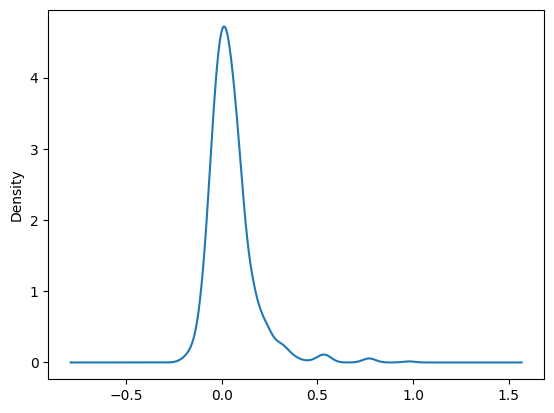

In [130]:
strategy_result(ticker, ror_col='close_ror-5d', threshold=0.1, condition_col='close_pct_rank')